# Hyperparameter Tuning Your Own R Algorithm with Your Own Container in Amazon SageMaker
_**Using Amazon SageMaker's Hyperparameter Tuning with a customer Docker container and R algorithm**_

---

**Read before running the notebook:**
- This notebook has been updated to SageMaker v2.0
- Use Python3 kernel for this notebook.
- Dockerfile has been updated to use [Amazon ECR Public Gallery](https://docs.aws.amazon.com/AmazonECR/latest/public/public-gallery.html)


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
  1. [Permissions](#Permissions)
1. [Code](#Code)
  1. [Publish](#Publish)
1. [Data](#Data)
1. [Tune](#Tune)
1. [HPO Analysis](#HPO-Analysis)
1. [Host](#Host)
1. [Predict](#Predict)
1. [(Optional) Clean-up](#(Optional)-Clean-up)
1. [Wrap-up](#Wrap-up)

---
## Background

R is a popular open source statistical programming language, with a lengthy history in Data Science and Machine Learning.  The breadth of algorithms available as R packages is impressive and fuels a diverse community of users.  In this example, we'll combine one of those algorithms ([Multivariate Adaptive Regression Splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines)) with SageMaker's hyperparameter tuning capabilities to build a simple model on.... 


This notebook will focus mainly on the integration of hyperparameter tuning and a custom algorithm container, as well as hosting the tuned model and making inference using the endpoint. For more examples, please see this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/r_bring_your_own/r_bring_your_own.ipynb).

---
## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the notebook instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/using-identity-based-policies.html) for more details on creating these.  Note, if a role not associated with the current notebook instance, or more than one role is required for training and/or hosting, please replace `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).

In [1]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/demo-r-byo"

role = sagemaker.get_execution_role()

Now we'll import the libraries we'll need for the remainder of the notebook.

In [2]:
import os
import boto3
import sagemaker
import pandas as pd
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll be creating a new repository in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role associated with your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

---
## Code

For this example, we'll need 3 supporting code files.  We'll provide just a brief overview of what each one does.  See the full R bring your own notebook for more details.

- **Fit**: `mars.R` creates functions to train and serve our model.
- **Serve**: `plumber.R` uses the [plumber](https://www.rplumber.io/) package to create a lightweight HTTP server for processing requests in hosting.  Note the specific syntax, and see the plumber help docs for additional detail on more specialized use cases.
- **Dockerfile**:  This specifies the configuration for our docker container.  Smaller containers are preferred for Amazon SageMaker as they lead to faster spin up times in training and endpoint creation, so this container is kept minimal. This docker file starts with base R image, installs `plumber` and `mda` libraries and their dependecies, then adds `mars.R` and `plumber.R`, and finally sets `mars.R` to run as the entrypoint when launched.

    - **Upodate:** The updated dockerfile leverages public R-Base image from [Amazon Public ECR Gallery](https://aws.amazon.com/about-aws/whats-new/2020/12/announcing-amazon-ecr-public-and-amazon-ecr-public-gallery/) which has been available since December 2020. Feel free to read more about this public gallery and browse for public images at https://gallery.ecr.aws/.

### Publish
Now, to publish this container to ECR, we'll run the comands below.

This command will take several minutes to run the first time.

In [3]:
algorithm_name = "rmars"

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=rmars

#set -e # stop if anything fails
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-eu-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# Get the login command from ECR and execute it directly
aws ecr get-login-password --region ${region} | docker login --username AWS --password-stdin ${account}.dkr.ecr.${region}.amazonaws.com

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

_Note: Although we could do preliminary data transformations in the notebook, we'll avoid doing so, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

---
## Tune

Now, let's setup the information needed to train a Multivariate Adaptive Regression Splines model on data.  In this case, we'll predict `Sepal.Length` rather than the more typical classification of `Species` in order to show how factors might be included in a model and to limit the use case to regression.

First, we'll get our region and account information so that we can point to the ECR container we just created.

In [ ]:
region = boto3.Session().region_name
account = boto3.client("sts").get_caller_identity().get("Account")

Now we'll create an estimator using the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk).  This allows us to specify:
- The training container image in ECR
- The IAM role that controls permissions for accessing the S3 data and executing SageMaker functions
- Number and type of training instances
- S3 path for model artifacts to be output to
- Any hyperparameters that we want to have the same value across all training jobs during tuning

In [ ]:
estimator = sagemaker.estimator.Estimator(
    image_uri="{}.dkr.ecr.{}.amazonaws.com/rmars:latest".format(account, region),
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker.Session(),
    hyperparameters={"target":'RAW',
                     "degree": 2},
)  # Setting constant hyperparameter

# target is by defauld "RAW". See mars.R where this is set.

Once we've defined our estimator we can specify the hyperparameters that we'd like to tune and their possible values.  We have three different types of hyperparameters.
- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

*Note, if possible, it's almost always best to specify a value as the least restrictive type.  For example, tuning `thresh` as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with possible values of 0.01, 0.1, 0.15, or 0.2.*

In [ ]:
# to set the degree as a varying HP to tune, use: 'degree': IntegerParameter(1, 3) and remove it from the Estimator

hyperparameter_ranges = {
    "thresh": ContinuousParameter(0.001, 0.01),
    "prune": CategoricalParameter(["TRUE", "FALSE"]),
}

Next we'll specify the objective metric that we'd like to tune and its definition.  This metric is output by a `print` statement in our `mars.R` file.  Its critical that the format aligns with the regular expression (Regex) we then specify to extract that metric from the CloudWatch logs of our training job.

In [ ]:
objective_metric_name = "mse"
metric_definitions = [{"Name": "mse", "Regex": "mse: ([0-9\\.]+)"}]

Now, we'll create a `HyperparameterTuner` object, which we pass:
- The MXNet estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Whether we should maximize or minimize our objective metric (defaults to 'Maximize')
- Number of training jobs to run in total and how many training jobs should be run simultaneously.  More parallel jobs will finish tuning sooner, but may sacrifice accuracy.  We recommend you set the parallel jobs value to less than 10% of the total number of training jobs (we'll set it higher just for this example to keep it short).

In [ ]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    objective_type="Minimize",
    max_jobs=9,
    max_parallel_jobs=3,
)

And finally, we can start our hyperparameter tuning job by calling `.fit()` and passing in the S3 paths to our train (and val) datasets.

*Note, typically for hyperparameter tuning, we'd want to specify both a training and validation dataset and optimize the objective metric from the validation dataset.  However, because data is a very small dataset we'll skip the step of splitting into training and validation.  In practice, doing this could lead to a model that overfits to our training data and does not generalize well.*

## Data

In [ ]:
ID=42022

In [ ]:
# train_file = "data/base_train.csv"
# boto3.Session().resource("s3").Bucket(bucket).Object(
#     os.path.join(prefix, "train", train_file)
# ).upload_file(train_file)

In [ ]:
# test_file = "data/base_test.csv"
# boto3.Session().resource("s3").Bucket(bucket).Object(
#     os.path.join(prefix, "train", test_file)
# ).upload_file(test_file)

# Fit!

In [ ]:
tuner.fit({"train": "s3://{}/{}/{}/train/base".format(bucket, prefix, ID)}, wait=False)

Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully and is `InProgress`.

In [ ]:
import time

status = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

while status != "Completed":
    status = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )["HyperParameterTuningJobStatus"]

    completed = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )["TrainingJobStatusCounters"]["Completed"]

    prog = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )["TrainingJobStatusCounters"]["InProgress"]

    print(f"{status}, Completed Jobs: {completed}, In Progress Jobs: {prog}")

    time.sleep(30)

Wait until the HPO job is complete, and then run the following cell:

In [ ]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["BestTrainingJob"]

---

## HPO Analysis

Now that we've started our hyperparameter tuning job, it will run in the background and we can close this notebook.  Once finished, we can use the [HPO Analysis notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to determine which set of hyperparameters worked best.

For more detail on Amazon SageMaker's Hyperparameter Tuning, please refer to the AWS documentation. 

---
## Host

Hosting the model we just tuned takes three steps in Amazon SageMaker.  First, we define the model we want to host, pointing the service to the model artifact our training job just wrote to S3.

We will use the results of the HPO for this purpose, but using `hyper_parameter_tuning_job` method.

In [ ]:
best_training = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["BestTrainingJob"]

In [ ]:
# Get the best trainig job and S3 location for the model file
best_model_s3 = boto3.client("sagemaker").describe_training_job(
    TrainingJobName=best_training["TrainingJobName"]
)["ModelArtifacts"]["S3ModelArtifacts"]
best_model_s3

In [ ]:
# import time

r_job = "demo-r-byo-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [ ]:
r_hosting_container = {
    "Image": "{}.dkr.ecr.{}.amazonaws.com/{}:latest".format(account, region, algorithm_name),
    "ModelDataUrl": best_model_s3,
}

create_model_response = boto3.client("sagemaker").create_model(
    ModelName=r_job, ExecutionRoleArn=role, PrimaryContainer=r_hosting_container
)

print(create_model_response["ModelArn"])

Next, let's create an endpoing configuration, passing in the model we just registered.  In this case, we'll only use a few c4.xlarges.

In [ ]:
r_endpoint_config = "demo-r-byo-config-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(r_endpoint_config)

create_endpoint_config_response = boto3.client("sagemaker").create_endpoint_config(
    EndpointConfigName=r_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.t2.medium",
            "InitialInstanceCount": 1,
            "ModelName": r_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Finally, we'll create the endpoints using our endpoint configuration from the last step.

In [ ]:
%%time

r_endpoint = "demo-r-endpoint-base" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(r_endpoint)
create_endpoint_response = boto3.client("sagemaker").create_endpoint(
    EndpointName=r_endpoint, EndpointConfigName=r_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = boto3.client("sagemaker").describe_endpoint(EndpointName=r_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

try:
    boto3.client("sagemaker").get_waiter("endpoint_in_service").wait(EndpointName=r_endpoint)
finally:
    resp = boto3.client("sagemaker").describe_endpoint(EndpointName=r_endpoint)
    status = resp["EndpointStatus"]
    print("Arn: " + resp["EndpointArn"])
    print("Status: " + status)

    if status != "InService":
        raise Exception("Endpoint creation did not succeed")

---
## Predict
To confirm our endpoints are working properly, let's try to invoke the endpoint.

_Note: The payload we're passing in the request is a CSV string with a header record, followed by multiple new lines.  It also contains text columns, which the serving code converts to the set of indicator variables needed for our model predictions.  Again, this is not a best practice for highly optimized code, however, it showcases the flexibility of bringing your own algorithm._

In [6]:
import pandas as pd
import json

runtime = boto3.Session().client("runtime.sagemaker")

In [56]:
base_test=pd.read_csv("data/base_test.csv")

In [57]:
# base_test = base_test[['RAW', 'temperature']]
base_test

,date,RAW,AUX,PPB,FINAL,temperature,humidity
0,2021-08-15T00:00:00Z,297.119781,291.050140,26.006405,47.910666,24.947952,71.825111
1,2021-08-15T00:05:00Z,297.190613,290.970703,26.640447,49.097793,24.840132,72.204788
2,2021-08-15T00:10:00Z,297.342926,290.953918,27.306863,50.342183,24.748535,72.435509
3,2021-08-15T00:15:00Z,297.423859,290.991669,27.467959,50.652240,24.667969,72.647430
4,2021-08-15T00:20:00Z,297.621857,291.080017,27.839642,51.338433,24.646229,72.760681
...,...,...,...,...,...,...,...
28508,2021-11-21T23:40:00Z,295.487457,289.743622,28.566249,38.411773,9.792356,90.688797
28509,2021-11-21T23:45:00Z,295.295471,289.648102,28.042028,37.708939,9.732252,90.711517
28510,2021-11-21T23:50:00Z,295.182678,289.622833,27.652140,37.187099,9.657760,90.995132
28511,2021-11-21T23:55:00Z,295.218353,289.417328,28.441753,38.283982,9.509255,91.640945


In [66]:
base_test2 = base_test[['temperature']].dropna()
base_test2

,temperature
0,24.947952
1,24.840132
2,24.748535
3,24.667969
4,24.646229
...,...
28507,9.791079
28508,9.792356
28509,9.732252
28510,9.657760


In [67]:
%%time

# there is a limit of max 500 samples at a time for invoking endpoints )?)
# payload = base_test.drop(["RAW"], axis=1).to_csv(index=False)
payload = base_test2.to_csv(index=False)


response = runtime.invoke_endpoint(EndpointName=r_endpoint, ContentType="text/csv", Body=payload)

result = json.loads(response["Body"].read().decode())
display(result)

['292.869972455218,292.935826785045,292.991771919069,293.040980058111,293.054258333887,293.096386978115,293.136760019465,293.136221805444,293.142570866944,293.145009139554,293.182063194442,293.196903688837,293.24147410057,293.298687881929,293.334423195971,293.362687586819,293.407795047607,293.468036574074,293.513583226823,293.576363212925,293.631428798063,293.675218682969,293.707877323355,293.723694058766,293.751324708429,293.757671439999,293.751667208261,293.769485354251,293.77793018853,293.802290780279,293.80517057478,293.829188666698,293.870391163422,293.913497213631,293.946057996922,293.968856370052,294.002100988041,294.038177636948,294.072300638858,294.105643113941,294.142792695993,294.189755946684,294.206256516793,294.235741791394,294.259614262635,294.279580604847,294.269523458438,294.25209557586,294.227638291982,294.220803439904,294.200788169145,294.192000835035,294.170814774036,294.114332590956,294.063513304748,294.009375032079,293.963681593688,293.917890298203,293.849448580194

CPU times: user 90.6 ms, sys: 0 ns, total: 90.6 ms
Wall time: 309 ms


We can see the result is a CSV of predictions for our target variable.  Let's compare them to the actuals to see how our model did.

In [51]:
payload

'temperature\n24.94795227050781\n24.840131759643555\n24.74853515625\n24.66796875\n24.646228790283203\n24.577253341674805\n24.51115226745605\n24.512033462524414\n24.501638412475586\n24.49764633178711\n24.43697929382324\n24.412681579589844\n24.33970832824707\n24.246034622192386\n24.18752670288086\n24.14125061035156\n24.067398071289066\n23.96876716613769\n23.894195556640625\n23.79140853881836\n23.701251983642567\n23.62955665588379\n23.576086044311523\n23.550189971923828\n23.50495147705078\n23.49456024169922\n23.50439071655273\n23.47521781921387\n23.46139144897461\n23.42150688171387\n23.416791915893555\n23.37746810913086\n23.31000900268555\n23.23943328857422\n23.18612289428711\n23.14879608154297\n23.0943660736084\n23.03529930114746\n22.97943115234375\n22.924840927124023\n22.864017486572266\n22.78712654113769\n22.76011085510254\n22.71183586120605\n22.67275047302246\n22.64006042480469\n22.65652656555176\n22.685060501098636\n22.7251033782959\n22.73629379272461\n22.76906394958496\n22.783451080

In [68]:
data_output = [float(x) for x in result[0].split(',')]

In [69]:
data_output

[292.869972455218,
 292.935826785045,
 292.991771919069,
 293.040980058111,
 293.054258333887,
 293.096386978115,
 293.136760019465,
 293.136221805444,
 293.142570866944,
 293.145009139554,
 293.182063194442,
 293.196903688837,
 293.24147410057,
 293.298687881929,
 293.334423195971,
 293.362687586819,
 293.407795047607,
 293.468036574074,
 293.513583226823,
 293.576363212925,
 293.631428798063,
 293.675218682969,
 293.707877323355,
 293.723694058766,
 293.751324708429,
 293.757671439999,
 293.751667208261,
 293.769485354251,
 293.77793018853,
 293.802290780279,
 293.80517057478,
 293.829188666698,
 293.870391163422,
 293.913497213631,
 293.946057996922,
 293.968856370052,
 294.002100988041,
 294.038177636948,
 294.072300638858,
 294.105643113941,
 294.142792695993,
 294.189755946684,
 294.206256516793,
 294.235741791394,
 294.259614262635,
 294.279580604847,
 294.269523458438,
 294.25209557586,
 294.227638291982,
 294.220803439904,
 294.200788169145,
 294.192000835035,
 294.17081477403

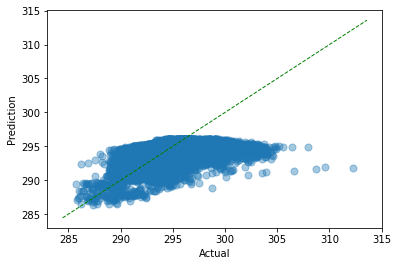

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(base_test["RAW"].dropna(), data_output, alpha=0.4, s=50)
# plt.scatter(base_test["RAW"], np.fromstring(result[0], sep=","), alpha=0.4, s=50)
plt.xlabel("Actual")
plt.ylabel("Prediction")
x = np.linspace(*plt.xlim())
plt.plot(x, x, linestyle="--", color="g", linewidth=1)

plt.show()

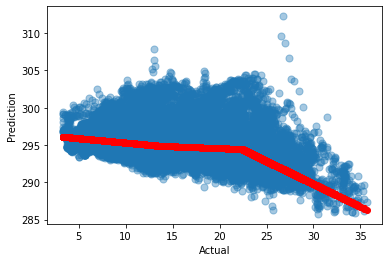

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(base_test["temperature"].dropna(), base_test["RAW"].dropna(), alpha=0.4, s=50)
plt.scatter(base_test["temperature"].dropna(), data_output, color="red")
plt.xlabel("Actual")
plt.ylabel("Prediction")
x = np.linspace(*plt.xlim())
# plt.plot(x, x, linestyle="--", color="g", linewidth=1)



plt.show()

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
#boto3.client("sagemaker").delete_endpoint(EndpointName=r_endpoint)

## gas model

In [80]:
gas_estimator = sagemaker.estimator.Estimator(
    image_uri="{}.dkr.ecr.{}.amazonaws.com/rmars:latest".format(account, region),
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker.Session(),
    hyperparameters={"target":'NO2',
                     "degree": 2},
)  # Setting constant hyperparameter

# target is by defauld "RAW". See mars.R where this is set.

In [81]:
# to set the degree as a varying HP to tune, use: 'degree': IntegerParameter(1, 3) and remove it from the Estimator

hyperparameter_ranges = {
    "thresh": ContinuousParameter(0.001, 0.01),
    "prune": CategoricalParameter(["TRUE", "FALSE"]),
}

In [82]:
objective_metric_name = "mse"
metric_definitions = [{"Name": "mse", "Regex": "mse: ([0-9\\.]+)"}]

In [84]:
gas_tuner = HyperparameterTuner(
    gas_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    objective_type="Minimize",
    max_jobs=9,
    max_parallel_jobs=3,
)

In [88]:
gas_tuner.fit({"train": "s3://{}/{}/{}/train/gas".format(bucket, prefix, ID)}, wait=False)

In [89]:
import time

status = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=gas_tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

while status != "Completed":
    status = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=gas_tuner.latest_tuning_job.job_name
    )["HyperParameterTuningJobStatus"]

    completed = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=gas_tuner.latest_tuning_job.job_name
    )["TrainingJobStatusCounters"]["Completed"]

    prog = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=gas_tuner.latest_tuning_job.job_name
    )["TrainingJobStatusCounters"]["InProgress"]

    print(f"{status}, Completed Jobs: {completed}, In Progress Jobs: {prog}")

    time.sleep(30)

InProgress, Completed Jobs: 0, In Progress Jobs: 0
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 0, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 1
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 3, In Progress Jobs: 3
InProgress, Completed Jobs: 6, In Progress Jobs: 3
InProgress, Completed Jobs: 6, In Progress Jobs: 3
InProgress, Completed Jobs: 6, 

Wait until the HPO job is complete, and then run the following cell:

In [90]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=gas_tuner.latest_tuning_job.job_name
)["BestTrainingJob"]

{'TrainingJobName': 'rmars-211208-1316-007-70b0d4e3',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:870953422121:training-job/rmars-211208-1316-007-70b0d4e3',
 'CreationTime': datetime.datetime(2021, 12, 8, 13, 25, 20, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2021, 12, 8, 13, 27, 35, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2021, 12, 8, 13, 29, 3, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'prune': 'FALSE', 'thresh': '0.0020718742226242203'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'mse',
  'Value': 7878.75439453125},
 'ObjectiveStatus': 'Succeeded'}

In [91]:
best_training = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=gas_tuner.latest_tuning_job.job_name
)["BestTrainingJob"]

In [92]:
# Get the best trainig job and S3 location for the model file
best_model_s3 = boto3.client("sagemaker").describe_training_job(
    TrainingJobName=best_training["TrainingJobName"]
)["ModelArtifacts"]["S3ModelArtifacts"]
best_model_s3

's3://sagemaker-eu-west-2-870953422121/sagemaker/demo-r-byo/output/rmars-211208-1316-007-70b0d4e3/output/model.tar.gz'

In [93]:
# import time

r_job = "demo-r-byo-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [94]:
r_hosting_container = {
    "Image": "{}.dkr.ecr.{}.amazonaws.com/{}:latest".format(account, region, algorithm_name),
    "ModelDataUrl": best_model_s3,
}

create_model_response = boto3.client("sagemaker").create_model(
    ModelName=r_job, ExecutionRoleArn=role, PrimaryContainer=r_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:eu-west-2:870953422121:model/demo-r-byo-2021-12-08-13-32-27


Next, let's create an endpoing configuration, passing in the model we just registered.  In this case, we'll only use a few c4.xlarges.

In [95]:
r_endpoint_config = "demo-r-byo-config-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(r_endpoint_config)

create_endpoint_config_response = boto3.client("sagemaker").create_endpoint_config(
    EndpointConfigName=r_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.t2.medium",
            "InitialInstanceCount": 1,
            "ModelName": r_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

demo-r-byo-config-2021-12-08-13-33-43
Endpoint Config Arn: arn:aws:sagemaker:eu-west-2:870953422121:endpoint-config/demo-r-byo-config-2021-12-08-13-33-43


Finally, we'll create the endpoints using our endpoint configuration from the last step.

In [96]:
%%time

r_endpoint = "demo-r-endpoint-gas" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(r_endpoint)
create_endpoint_response = boto3.client("sagemaker").create_endpoint(
    EndpointName=r_endpoint, EndpointConfigName=r_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = boto3.client("sagemaker").describe_endpoint(EndpointName=r_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

try:
    boto3.client("sagemaker").get_waiter("endpoint_in_service").wait(EndpointName=r_endpoint)
finally:
    resp = boto3.client("sagemaker").describe_endpoint(EndpointName=r_endpoint)
    status = resp["EndpointStatus"]
    print("Arn: " + resp["EndpointArn"])
    print("Status: " + status)

    if status != "InService":
        raise Exception("Endpoint creation did not succeed")

demo-r-endpoint-gas202112081333
arn:aws:sagemaker:eu-west-2:870953422121:endpoint/demo-r-endpoint-gas202112081333
Status: Creating
Arn: arn:aws:sagemaker:eu-west-2:870953422121:endpoint/demo-r-endpoint-gas202112081333
Status: InService
CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 3min 1s


In [10]:
r_endpoint ='demo-r-endpoint-gas202112081333'

In [7]:
gas_test=pd.read_csv("data/gas_test.csv", index_col=0)
gas_test.index = pd.to_datetime(gas_test.index)
                    

In [8]:
gas_test2 = gas_test[['RAW', 'temperature']].dropna()
gas_test2

,RAW,temperature
date,,
2021-09-15 00:00:00+00:00,297.185778,17.105836
2021-09-15 01:00:00+00:00,296.608752,16.603349
2021-09-15 02:00:00+00:00,295.917348,16.113097
2021-09-15 03:00:00+00:00,295.933439,15.674770
2021-09-15 04:00:00+00:00,296.054749,15.393068
...,...,...
2021-11-21 19:00:00+00:00,295.475538,10.584067
2021-11-21 20:00:00+00:00,295.382703,10.379441
2021-11-21 21:00:00+00:00,295.487480,10.144782


In [11]:
%%time

# there is a limit of max 500 samples at a time for invoking endpoints )?)
# payload = base_test.drop(["RAW"], axis=1).to_csv(index=False)
payload = gas_test2.to_csv(index=False)


response = runtime.invoke_endpoint(EndpointName=r_endpoint, ContentType="text/csv", Body=payload)

result = json.loads(response["Body"].read().decode())
display(result)

['21.2202695940286,18.4865877401568,15.1298667136166,15.2589548272086,15.9021220415102,18.1425803627168,20.5005630070255,21.3877311085071,16.5770693024657,12.8301977346975,14.1864530877615,9.98951054449777,5.45514468073328,6.20463275482287,7.89410334979252,14.8077743737437,13.2975588401352,23.6002204782801,33.2681254637936,37.9022036829247,34.3130768986381,31.2951506276001,28.3963294077975,22.3986961977127,21.3361538920737,19.8358123496524,17.711167429556,18.089348241964,18.844523537324,22.3192381089966,24.5091735393293,20.6267417567067,18.4786304169696,14.9639658249762,14.8370131204569,14.8035759514535,13.8188739628989,15.610993453426,12.6599426619549,15.268505547088,24.0131932192296,28.1437806728311,37.4768485312658,29.8081745798688,28.0595555934416,21.4138520299208,16.0979846847063,16.8407664743443,14.5117165029436,13.7303911052923,10.0893787934858,10.8145579027442,11.3044459592347,14.8333778727579,9.98016445294099,18.4981561652109,25.0860284334053,24.640287778026,20.5341837416742,1

CPU times: user 31.3 ms, sys: 154 µs, total: 31.4 ms
Wall time: 100 ms


We can see the result is a CSV of predictions for our target variable.  Let's compare them to the actuals to see how our model did.

In [102]:
payload

'RAW,temperature\n297.1857782999675,17.105836391448975\n296.60875193278,16.603348731994632\n295.91734822591144,16.113096555074055\n295.9334386189778,15.67477035522461\n296.05474853515625,15.393067598342896\n296.49836476643884,15.370748043060305\n297.0045878092448,16.309357325236007\n297.21808624267584,17.500329335530598\n296.2027282714844,19.55810340245565\n294.87452697753906,21.72143348058065\n294.9954579671224,23.58313306172689\n292.8767217000325,25.38868347803752\n290.30064646403,27.220983346303306\n290.546137491862,28.779546896616623\n291.7063954671224,29.130292733510327\n293.8583628336589,28.47689565022786\n295.4325408935547,27.547671476999923\n297.5519256591797,25.899963855743408\n299.1994603474935,24.392733732859288\n300.3917999267578,23.19167073567708\n299.82379659016925,22.282327969868973\n299.15522511800134,21.54658031463623\n298.48841349283856,21.211206754048664\n297.3263651529948,20.84250990549723\n297.1318359375,20.300478458404537\n296.8432261149089,19.955366611480716\n296

In [12]:
gas_output = [float(x) for x in result[0].split(',')]

In [13]:
gas_output

[21.2202695940286,
 18.4865877401568,
 15.1298667136166,
 15.2589548272086,
 15.9021220415102,
 18.1425803627168,
 20.5005630070255,
 21.3877311085071,
 16.5770693024657,
 12.8301977346975,
 14.1864530877615,
 9.98951054449777,
 5.45514468073328,
 6.20463275482287,
 7.89410334979252,
 14.8077743737437,
 13.2975588401352,
 23.6002204782801,
 33.2681254637936,
 37.9022036829247,
 34.3130768986381,
 31.2951506276001,
 28.3963294077975,
 22.3986961977127,
 21.3361538920737,
 19.8358123496524,
 17.711167429556,
 18.089348241964,
 18.844523537324,
 22.3192381089966,
 24.5091735393293,
 20.6267417567067,
 18.4786304169696,
 14.9639658249762,
 14.8370131204569,
 14.8035759514535,
 13.8188739628989,
 15.610993453426,
 12.6599426619549,
 15.268505547088,
 24.0131932192296,
 28.1437806728311,
 37.4768485312658,
 29.8081745798688,
 28.0595555934416,
 21.4138520299208,
 16.0979846847063,
 16.8407664743443,
 14.5117165029436,
 13.7303911052923,
 10.0893787934858,
 10.8145579027442,
 11.3044459592347

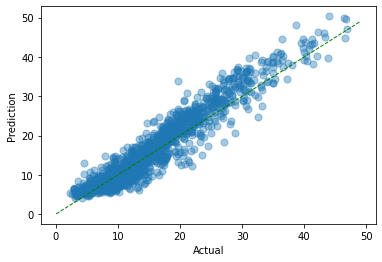

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(gas_test["NO2"].dropna(), gas_output, alpha=0.4, s=50)
# plt.scatter(base_test["RAW"], np.fromstring(result[0], sep=","), alpha=0.4, s=50)
plt.xlabel("Actual")
plt.ylabel("Prediction")
x = np.linspace(*plt.xlim())
plt.plot(x, x, linestyle="--", color="g", linewidth=1)

plt.show()

In [135]:
print(gas_test)

                                  RAW         AUX        PPB      FINAL  \
date                                                                      
2021-09-15 00:00:00+00:00  297.185778  290.417313  30.911137  49.279743   
2021-09-15 01:00:00+00:00  296.608752  290.418505  28.795476  46.565638   
2021-09-15 02:00:00+00:00  295.917348  290.337786  26.485758  43.578565   
2021-09-15 03:00:00+00:00  295.933439  290.264954  26.947945  44.241682   
2021-09-15 04:00:00+00:00  296.054749  290.266474  27.519406  45.035146   
...                               ...         ...        ...        ...   
2021-11-21 19:00:00+00:00  295.475538  289.428421  29.243332  39.168235   
2021-11-21 20:00:00+00:00  295.382703  289.601629  28.379795  38.039439   
2021-11-21 21:00:00+00:00  295.487480  289.498060  29.198990  39.199012   
2021-11-21 22:00:00+00:00  295.493629  289.518295  29.320469  39.452827   
2021-11-21 23:00:00+00:00  295.536031  289.706749  28.933735  38.932736   

                        

In [131]:
print(type(gas_test.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


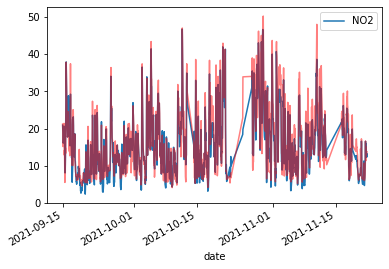

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# x = list(range(0,100))
# y = list(range(0, 200, 2))
# plt.scatter(x,y)
#print(gas_test['NO2'])
gas_test[['NO2']].plot()

#plt.plot(gas_test.index, gas_test['NO2'])
# plt.plot(gas_test[["NO2"]])
# plt.plot(gas_test["date"], gas_test["NO2"], alpha=0.5)
plt.plot(gas_test.index, gas_output, color="red", alpha=0.5)
# plt.xlabel("Actual")
# plt.ylabel("Prediction")
# x = np.linspace(*plt.xlim())
# plt.plot(x, x, linestyle="--", color="g", linewidth=1)


plt.show()